In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display
%matplotlib inline
sns.set(style="whitegrid")

# Load dataset
df = pd.read_csv("../data/Telco-Customer-Churn.csv")

# Show the shape and first few rows
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [2]:
# Data types
df.info()

# Nulls and empty strings
print("\nMissing values:")
print(df.isnull().sum())

# Check for blanks (some missing values are whitespace)
print("\nBlank values:")
print((df == " ").sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


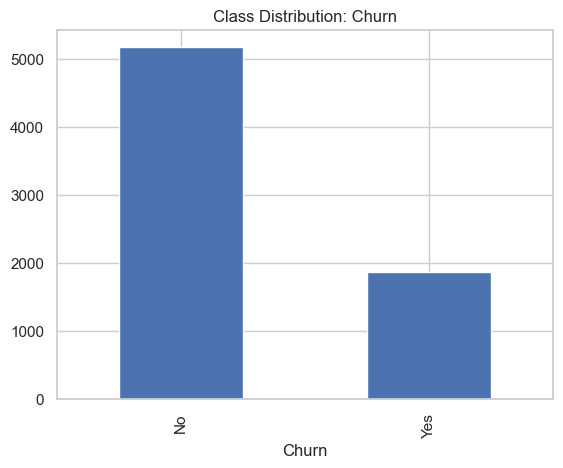

Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


In [3]:
# Churn value counts
df['Churn'].value_counts().plot(kind='bar', title='Class Distribution: Churn')
plt.show()

# Optional: Display percentages
churn_dist = df['Churn'].value_counts(normalize=True) * 100
print(churn_dist)


In [4]:
# Replace blank strings with NaN and convert
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'].replace(" ", np.nan), errors='coerce')

# Check how many are NaN
print("TotalCharges nulls after conversion:", df['TotalCharges'].isnull().sum())

# Option 1: Drop rows with null TotalCharges (few)
df.dropna(subset=['TotalCharges'], inplace=True)

# Option 2 (alternative): Fill with median or 0
# df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


TotalCharges nulls after conversion: 11


In [5]:
from sklearn.preprocessing import LabelEncoder

# Drop irrelevant columns
df.drop(['customerID'], axis=1, inplace=True)

# Convert target variable to binary
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Identify categorical columns
cat_cols = df.select_dtypes(include='object').columns.tolist()

# Apply Label Encoding (can use OneHot later if needed)
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])


In [6]:
from sklearn.model_selection import train_test_split

X = df.drop("Churn", axis=1)
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [8]:
import mlflow
import mlflow.sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Start MLflow experiment
mlflow.set_experiment("churn-prediction")

with mlflow.start_run():
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    # Metrics
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds)
    rec = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)

    # Log parameters and metrics
    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("precision", prec)
    mlflow.log_metric("recall", rec)
    mlflow.log_metric("f1_score", f1)

    # Log model
    mlflow.sklearn.log_model(model, "logistic_model")

    print(f"Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, F1: {f1:.3f}")


c:\Users\kenec\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2025/04/06 14:03:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Accuracy: 0.796, Precision: 0.628, Recall: 0.570, F1: 0.597


In [9]:
import mlflow.models
from mlflow.models.signature import infer_signature

# Infer model signature
input_example = X_test.iloc[:1]
signature = infer_signature(X_test, model.predict(X_test))

# Log model with signature and input
mlflow.sklearn.log_model(
    sk_model=model,
    artifact_path="logistic_model",
    input_example=input_example,
    signature=signature
)


c:\Users\kenec\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
